# Short Photoreceptor Diversity 
Explore differences in the connectivity of short photoreceptor (R1-6) subtypes

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os.path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
import statsmodels.api as sm

from src.dataframe_tools import extract_connector_table
from src.cartridge_metadata import ret_clusters
from vis.fig_tools import subtype_cm
from vis.hex_lattice import hexplot

import matplotlib as mpl
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D

In [26]:
plt.rcdefaults()
plt.style.use('vis/lamina.mplstyle')

save_figs = True

In [9]:
# synaptic links (contacts)
tp = '200914'
data_path = f'~/Data/{tp}_lamina/{tp}_linkdf.pickle'
df = pd.read_pickle(data_path)

# Rhabdom vols from Anastasia
rb = pd.read_csv('~/Data/lamina_additional_data/ret_cell_vol.csv').set_index('rtype').T
rb.index.name = 'om'
rb = rb.loc[sorted(rb.index), sorted(rb.columns)]
rb_frac = (rb.T/rb.sum(axis=1)).T.rename(mapper={'vol': 'fvol'}, axis=1)

rtypes = rb.columns
subtypes = np.unique(df['post_type'])
ommatidia = np.unique(df['pre_om'])

ret_clust = ret_clusters()

cm = subtype_cm()

ct_df = extract_connector_table(df) # DataFrame of connectors (presyn terminals)

In [10]:
# We are interested in both the number of contacts and the number of terminals 
n_terminals = {om: dict.fromkeys(rtypes) for om in ommatidia}
n_contacts = {om: dict.fromkeys(rtypes) for om in ommatidia}
n_outs = df['pre_neuron'].value_counts().to_dict() # count of links associated with every neuron

# Filter out non-short PR contacts/terminals
# TODO: helper function to add column for sub sub type (e.g. 'R1' instead of R1R4)
# This can be done from link_df, TODO: MAKE MORE GENERAL AND PUT IN DATAFRAME TOOLS
for pre_name, these_rows in ct_df.groupby('pre_neuron'):
    # using our neuron name pattern to get ommatidium/rtypes of indv photoreceptors
    if pre_name[0:2] == 'om' and pre_name[5] == 'R':  
        om = pre_name[2: 4]
        r = pre_name.split('_')[1]
        assert(len(r) in (2, 3))
        n_terminals[om][r] = len(these_rows)
        n_contacts[om][r] = n_outs.get(pre_name, 0)
    else:
        continue

terms = pd.DataFrame(n_terminals).fillna(0).astype(int).T
ctx = pd.DataFrame(n_contacts).fillna(0).astype(int).T

terms.index.name = 'om'
ctx.index.name = 'om'

In [46]:
# fig, axes = plt.subplots(3, 3, figsize=[9, 9])

# for i, ax in enumerate(axes.flatten()):
#     hexplot(terms.iloc[:, i], ax=ax)

In [47]:
# fig, axes = plt.subplots(3, 3, figsize=[9, 9])

# for i, ax in enumerate(axes.flatten()):
#     hexplot_TEST(terms.iloc[:, i], ax=ax, var_lim=[0, terms.iloc[:, i].max()])

In [31]:
# Longform dataframes for seaborn functions
# Alternatives: number of contacts or number of pre terminals, rhabdomere vol or faction of rhabdom total
# Decide which is concatenated in combined

l_terms = pd.melt(terms.reset_index(), id_vars='om', value_vars=terms.columns, var_name='subtype', value_name='term_count')
l_rbfrac = pd.melt(rb_frac.reset_index(), id_vars='om', value_vars=rb_frac.columns,  var_name='subtype', value_name='fvol')
l_ctx = pd.melt(ctx.reset_index(), id_vars='om', value_vars=ctx.columns, var_name='subtype', value_name='syn_count')
l_rb = pd.melt(rb.reset_index(), id_vars='om', value_vars=rb.columns,  var_name='subtype', value_name='vol')

# combined has fields for 'vol': raw volume, 'fvol': fractional volume, 'syn_count': connection count, 'term_count': terminal count 
combined = pd.concat([l_rb, l_rbfrac['fvol'], l_ctx['syn_count'], l_terms['term_count']], axis=1)


In [32]:
data = combined.loc[[i for i, row in combined.iterrows() if row['subtype'] not in ['R7', 'R7p', 'R8']]]
multi = (data['syn_count']/data['term_count']).mean()
multi_sd = (data['syn_count']/data['term_count']).std(ddof=0)

display(len(data))
display(multi)
display(multi_sd)

174

8.047813708716344

1.1999115888661174

## Differences between pairs of opposite short photoreceptor

### **Fraction of rhabdom volume** vs **number of synaptic outputs**

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              syn_count   R-squared:                       0.315
Model:                            OLS   Adj. R-squared:                  0.311
Method:                 Least Squares   F-statistic:                     79.08
Date:                Wed, 16 Dec 2020   Prob (F-statistic):           7.95e-16
Time:                        13:08:26   Log-Likelihood:                -752.05
No. Observations:                 174   AIC:                             1508.
Df Residuals:                     172   BIC:                             1514.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         54.7401      3.305     16.561      0.000      48.216      61.264
vol            7.4182      0.834      8.893      0.000       5.772       9.065
==============================================================================
Omnibus:                        0.076   Durbin-Watson:                   1.392
Prob(Omnibus):                  0.963   Jarque-Bera (JB):                0.062
Skew:                           0.042   Prob(JB):                        0.970
Kurtosis:                       2.962   Cond. No.                         9.92
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

/mnt/home/nchua/miniconda3/envs/wasp-lite/lib/python3.8/site-packages/seaborn/distributions.py:1649: FutureWarning: The `vertical` parameter is deprecated and will be removed in a future version. Assign the data to the `y` variable instead.
  warnings.warn(msg, FutureWarning)
/mnt/home/nchua/miniconda3/envs/wasp-lite/lib/python3.8/site-packages/seaborn/distributions.py:1649: FutureWarning: The `vertical` parameter is deprecated and will be removed in a future version. Assign the data to the `y` variable instead.
  warnings.warn(msg, FutureWarning)
/mnt/home/nchua/miniconda3/envs/wasp-lite/lib/python3.8/site-packages/seaborn/distributions.py:1649: FutureWarning: The `vertical` parameter is deprecated and will be removed in a future version. Assign the data to the `y` variable instead.
  warnings.warn(msg, FutureWarning)


const    54.740074
vol       7.418179
dtype: float64

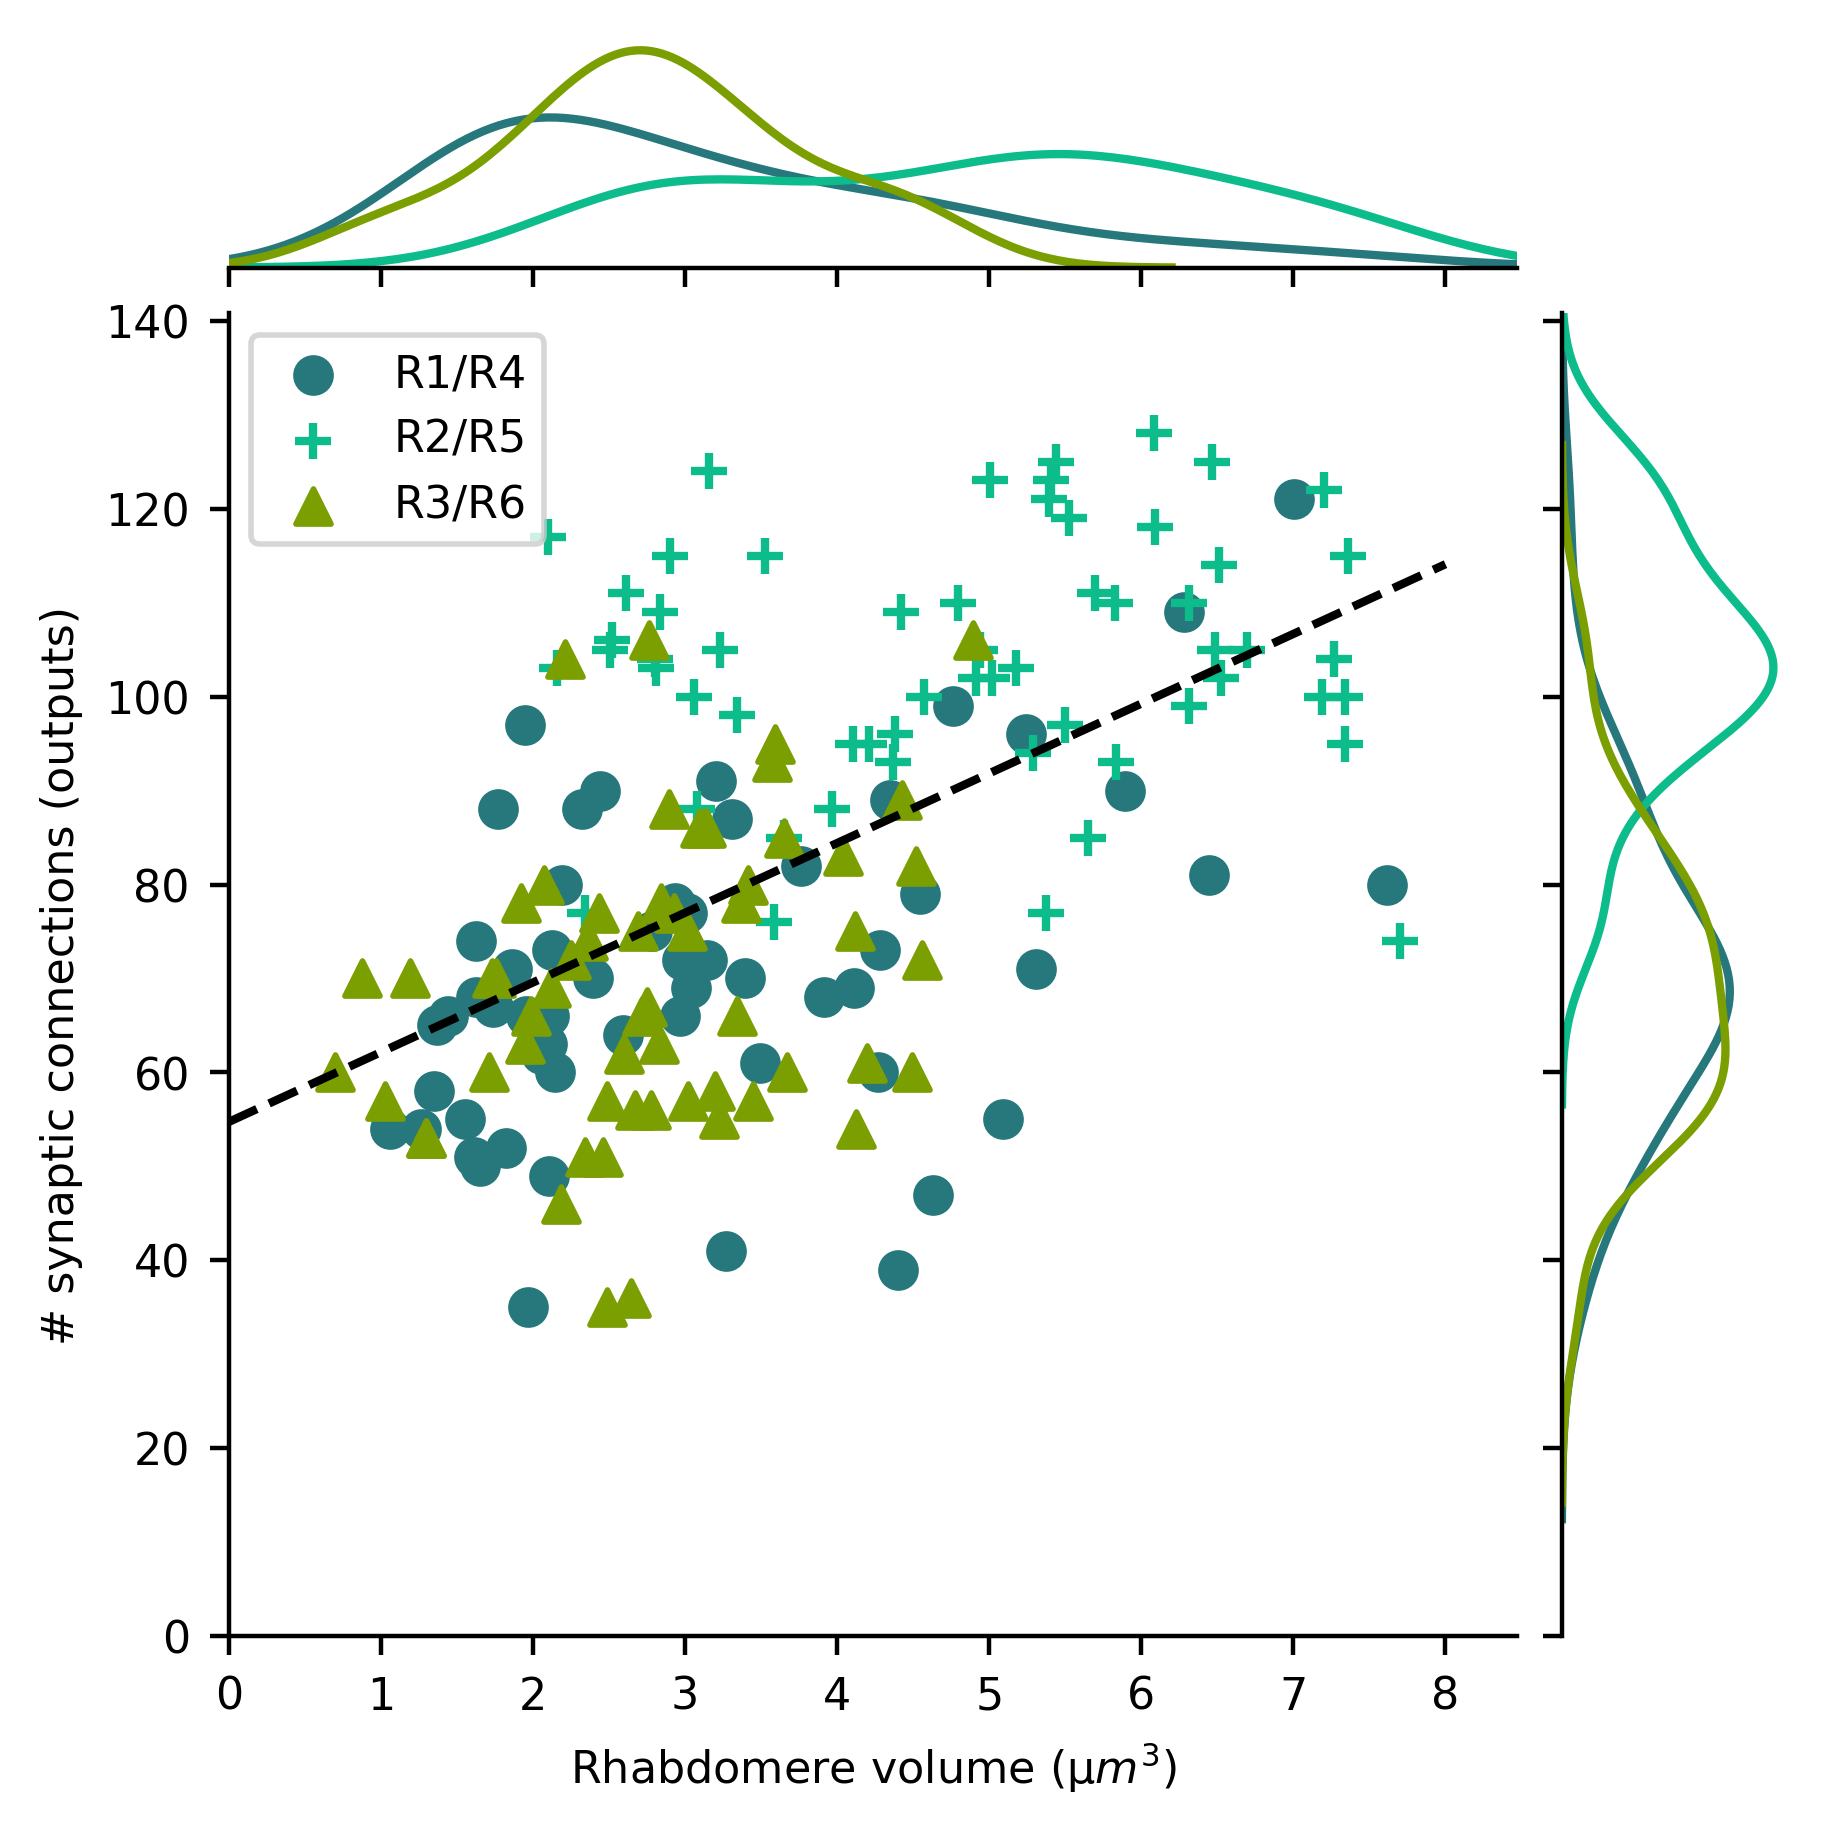

In [44]:
###### VARIABLES TO PLOT AND TEST ######
x_var = 'vol'  
y_var = 'syn_count'  
data = combined.loc[[i for i, row in combined.iterrows() if row['subtype'] not in ['R7', 'R7p', 'R8']]]

## OLS ##
_x = data[x_var] 
X = sm.add_constant(_x)
Y = data[y]

model = sm.OLS(Y, X)
results = model.fit()
params = results.params
display(results.summary())

xmax = data[x_var].max()
ymax = data[y_var].max()

g = sns.JointGrid(x=x_var, y=y_var, data=data, height=4.6,
                  xlim=[0, xmax + (xmax*0.1)], ylim=[0, ymax + (ymax*0.1)])

### Aesthetics ###
spr_pairs = (('R1', 'R4'), ('R2' , 'R5'), ('R3', 'R6'))
pt = ('o', '+', '^')

for i, p in enumerate(spr_pairs):
    rows = (data['subtype'] == p[0]) | (data['subtype'] == p[1])
    
    c = cm[p[0]+p[1]]
    
    g.ax_joint.scatter(x=data.loc[rows, x_var], y=data.loc[rows, y_var], 
                       label=f'{p[0]}/{p[1]}', marker=pt[i], color=c, s=40)
    g.ax_joint.legend(loc='upper left')
    
    sns.kdeplot(data.loc[rows, x_var], legend=False, ax=g.ax_marg_x, color=c)
    sns.kdeplot(data.loc[rows, y_var], legend=False, ax=g.ax_marg_y, vertical=True, color=c)

if x_var == 'fvol':
    g.ax_joint.set_xlabel("Fraction of total rhabdom volume")
else:
    g.ax_joint.set_xlabel('Rhabdomere volume (\u03BC$m^3$)')
        
if y_var == 'syn_count':
    g.ax_joint.set_ylabel("# synaptic connections (outputs)")
else:
    g.ax_joint.set_ylabel('# presynaptic terminals')

display(params)
xx = np.arange(0.0, max(_x) + 1.0)
g.ax_joint.plot(xx, params['const'] + params[x_var] * xx, c='k', ls='--')

if save_figs:
    g.savefig(f"/mnt/home/nchua/Dropbox/lamina_figures/pr-{x_var}-{y_var}.svg")
    g.savefig(f"/mnt/home/nchua/Dropbox/lamina_figures/pr-{x_var}-{y_var}.png")

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              syn_count   R-squared:                       0.270
Model:                            OLS   Adj. R-squared:                  0.265
Method:                 Least Squares   F-statistic:                     63.49
Date:                Wed, 16 Dec 2020   Prob (F-statistic):           2.12e-13
Time:                        13:08:35   Log-Likelihood:                -757.63
No. Observations:                 174   AIC:                             1519.
Df Residuals:                     172   BIC:                             1526.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         47.6607      4.472     10.658      0.000      38.834      56.488
fvol         374.6995     47.025      7.968      0.000     281.880     467.519
==============================================================================
Omnibus:                        0.629   Durbin-Watson:                   1.538
Prob(Omnibus):                  0.730   Jarque-Bera (JB):                0.729
Skew:                           0.010   Prob(JB):                        0.694
Kurtosis:                       2.683   Cond. No.                         33.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

/mnt/home/nchua/miniconda3/envs/wasp-lite/lib/python3.8/site-packages/seaborn/distributions.py:1649: FutureWarning: The `vertical` parameter is deprecated and will be removed in a future version. Assign the data to the `y` variable instead.
  warnings.warn(msg, FutureWarning)
/mnt/home/nchua/miniconda3/envs/wasp-lite/lib/python3.8/site-packages/seaborn/distributions.py:1649: FutureWarning: The `vertical` parameter is deprecated and will be removed in a future version. Assign the data to the `y` variable instead.
  warnings.warn(msg, FutureWarning)
/mnt/home/nchua/miniconda3/envs/wasp-lite/lib/python3.8/site-packages/seaborn/distributions.py:1649: FutureWarning: The `vertical` parameter is deprecated and will be removed in a future version. Assign the data to the `y` variable instead.
  warnings.warn(msg, FutureWarning)


const     47.660743
fvol     374.699534
dtype: float64

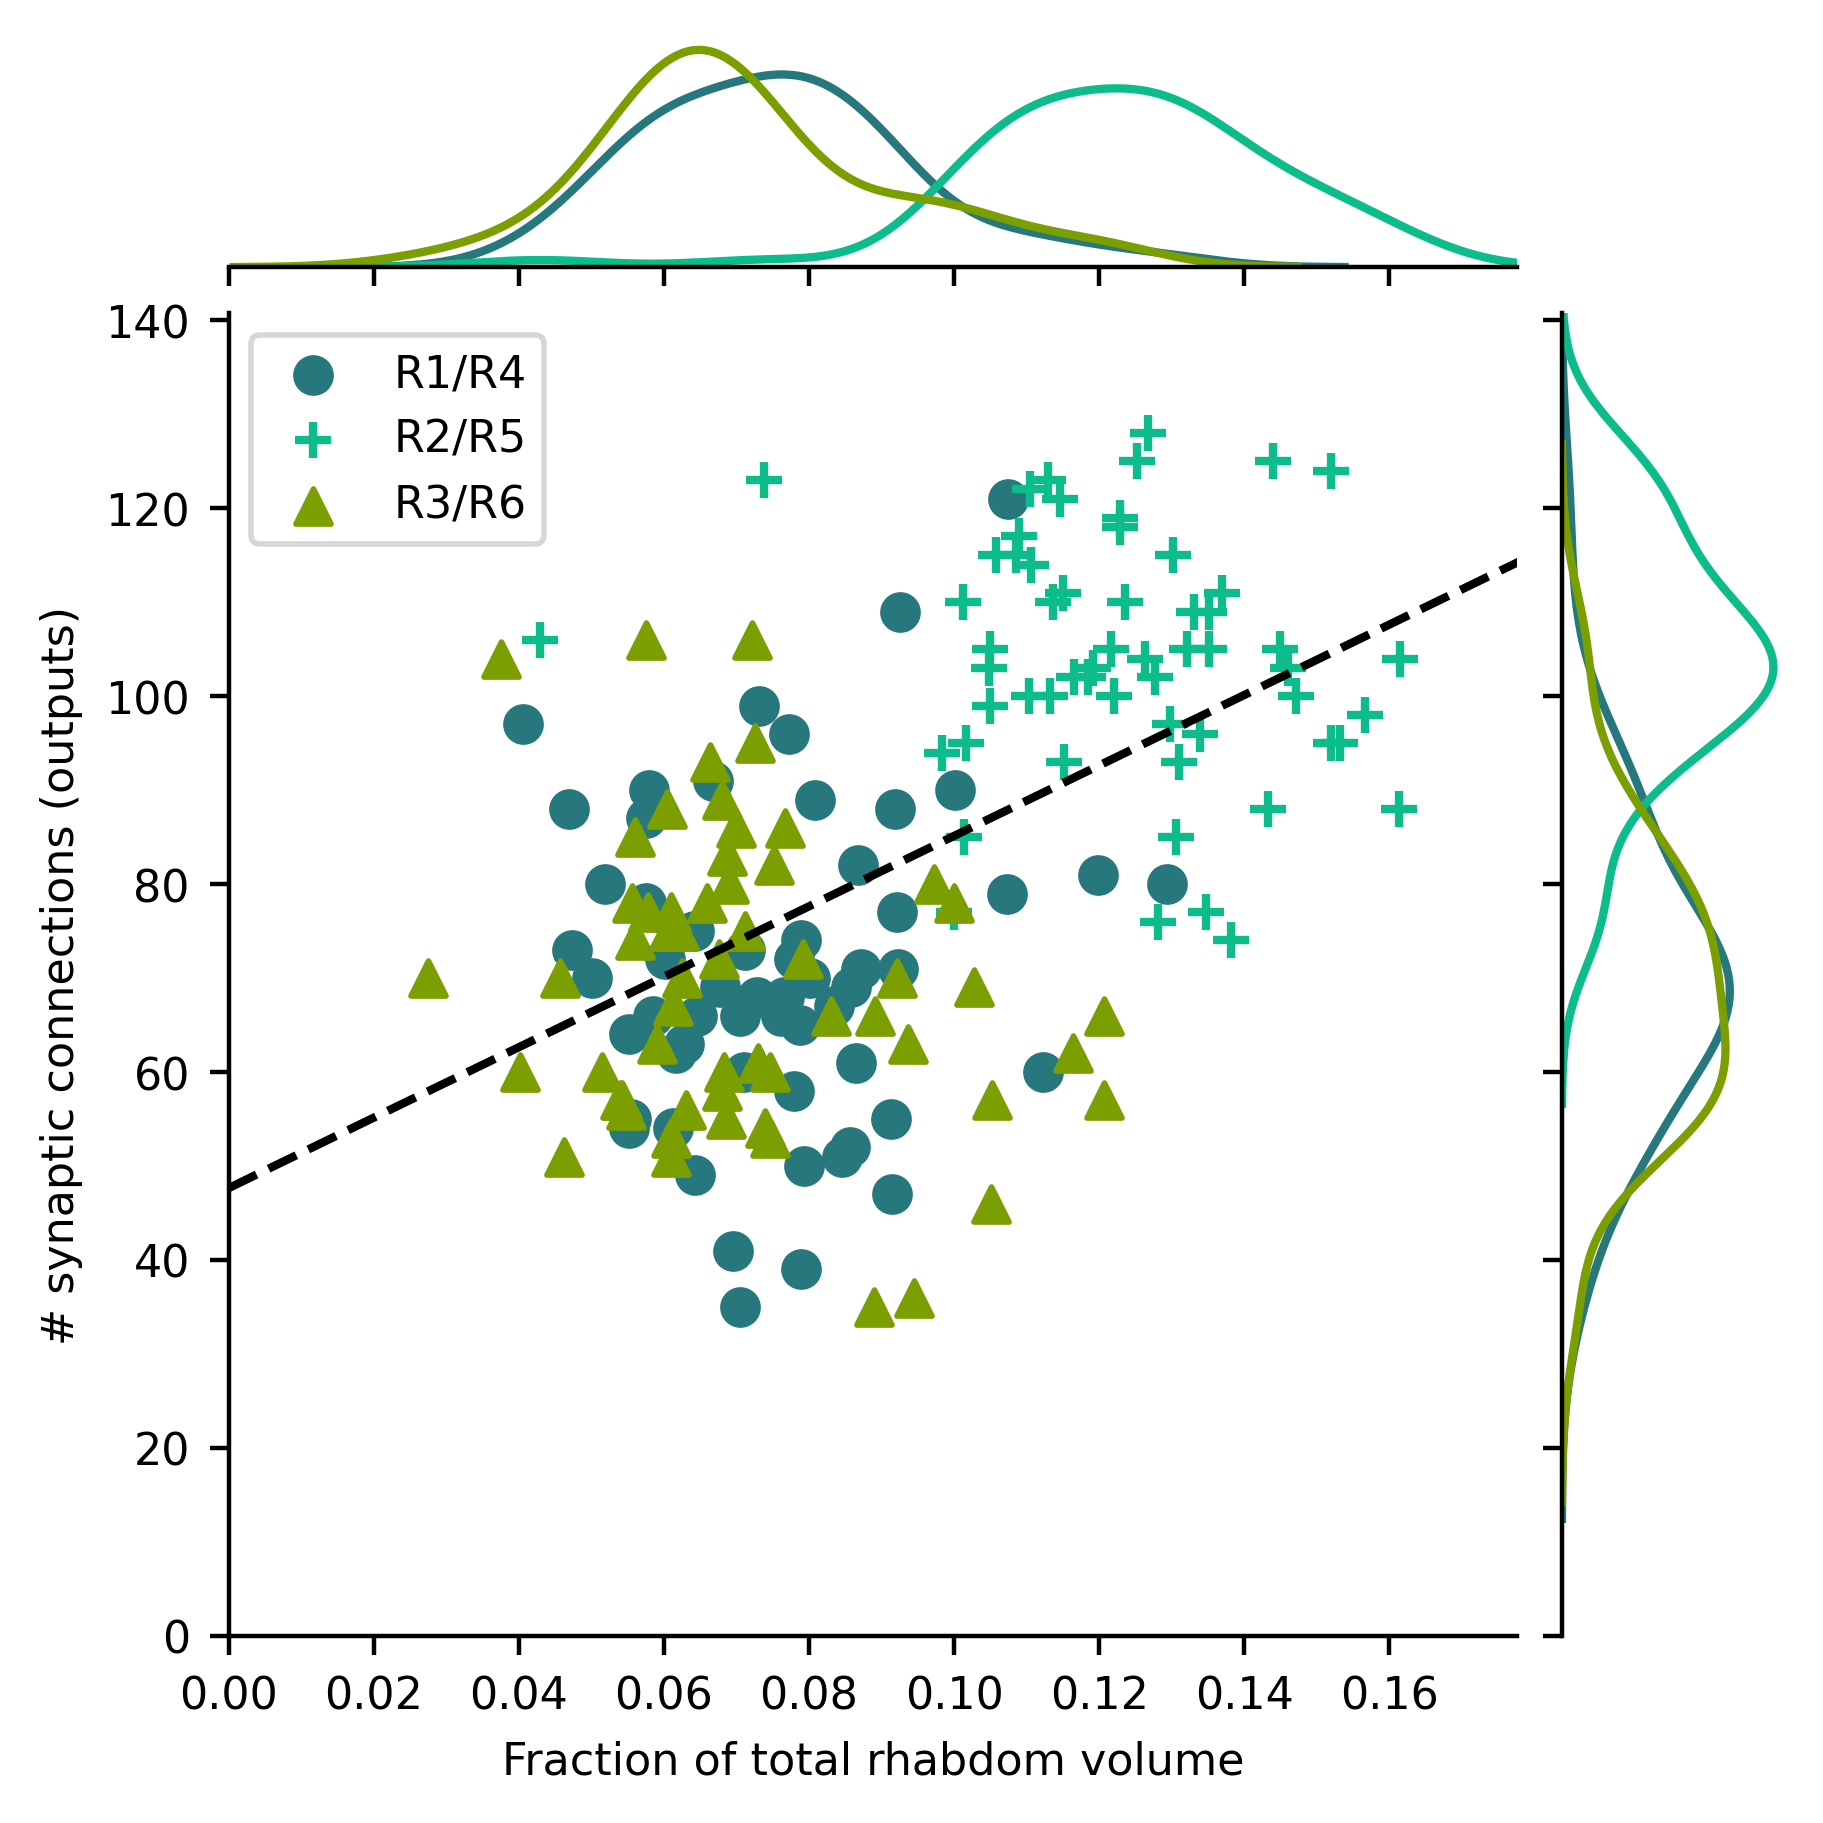

In [45]:
###### VARIABLES TO PLOT AND TEST ######
x_var = 'fvol'  
y_var = 'syn_count'  
data = combined.loc[[i for i, row in combined.iterrows() if row['subtype'] not in ['R7', 'R7p', 'R8']]]

## OLS ##
_x = data[x_var] 
X = sm.add_constant(_x)
Y = data[y]

model = sm.OLS(Y, X)
results = model.fit()
params = results.params
display(results.summary())

xmax = data[x_var].max()
ymax = data[y_var].max()

g = sns.JointGrid(x=x_var, y=y_var, data=data, height=4.6,
                  xlim=[0, xmax + (xmax*0.1)], ylim=[0, ymax + (ymax*0.1)])

### Aesthetics ###
spr_pairs = (('R1', 'R4'), ('R2' , 'R5'), ('R3', 'R6'))
pt = ('o', '+', '^')

for i, p in enumerate(spr_pairs):
    rows = (data['subtype'] == p[0]) | (data['subtype'] == p[1])
    
    c = cm[p[0]+p[1]]
    
    g.ax_joint.scatter(x=data.loc[rows, x_var], y=data.loc[rows, y_var], 
                       label=f'{p[0]}/{p[1]}', marker=pt[i], color=c, s=40)
    g.ax_joint.legend(loc='upper left')
    
    sns.kdeplot(data.loc[rows, x_var], legend=False, ax=g.ax_marg_x, color=c)
    sns.kdeplot(data.loc[rows, y_var], legend=False, ax=g.ax_marg_y, vertical=True, color=c)

if x_var == 'fvol':
    g.ax_joint.set_xlabel("Fraction of total rhabdom volume")
else:
    g.ax_joint.set_xlabel('Rhabdomere volume (\u03BC$m^3$)')
        
if y_var == 'syn_count':
    g.ax_joint.set_ylabel("# synaptic connections (outputs)")
else:
    g.ax_joint.set_ylabel('# presynaptic terminals')

display(params)
xx = np.arange(0.0, max(_x) + 1.0)
g.ax_joint.plot(xx, params['const'] + params[x_var] * xx, c='k', ls='--')

if save_figs:
    g.savefig(f"/mnt/home/nchua/Dropbox/lamina_figures/pr-{x_var}-{y_var}.svg")
    g.savefig(f"/mnt/home/nchua/Dropbox/lamina_figures/pr-{x_var}-{y_var}.png")

## Correlation between rhabdomere volume and number of presynaptic terminals
- [statsmodel OLS](https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.OLS.html)
- [why R-squared is so high when no intercept is fitted?](https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faq-why-are-r2-and-f-so-large-for-models-without-a-constant/)

In [7]:
data = combined.loc[[i for i, row in combined.iterrows() if row['subtype'] not in ['R7', 'R7p', 'R8']]]

X = data[x] 
X = sm.add_constant(X)
Y = data[y]

model = sm.OLS(Y, X)
results = model.fit()

display(results.summary())

/mnt/home/nchua/miniconda3/envs/wasp/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              syn_count   R-squared:                       0.270
Model:                            OLS   Adj. R-squared:                  0.265
Method:                 Least Squares   F-statistic:                     63.49
Date:                Fri, 06 Nov 2020   Prob (F-statistic):           2.12e-13
Time:                        12:39:22   Log-Likelihood:                -757.63
No. Observations:                 174   AIC:                             1519.
Df Residuals:                     172   BIC:                             1526.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         47.6607      4.472     10.658      0.000      38.834      56.488
fvol         374.6995     47.025      7.968      0.000     281.880     467.519
==============================================================================
Omnibus:                        0.629   Durbin-Watson:                   1.538
Prob(Omnibus):                  0.730   Jarque-Bera (JB):                0.729
Skew:                           0.010   Prob(JB):                        0.694
Kurtosis:                       2.683   Cond. No.                         33.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [8]:
data = combined.loc[[i for i, row in combined.iterrows() if row['subtype'] not in ['R7', 'R7p', 'R8']]]

X = data['fvol']
X = sm.add_constant(X)
Y = data['term_count']

model = sm.OLS(Y, X)
results = model.fit()

display(results.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             term_count   R-squared:                       0.298
Model:                            OLS   Adj. R-squared:                  0.294
Method:                 Least Squares   F-statistic:                     73.17
Date:                Fri, 06 Nov 2020   Prob (F-statistic):           6.34e-15
Time:                        12:39:23   Log-Likelihood:                -364.25
No. Observations:                 174   AIC:                             732.5
Df Residuals:                     172   BIC:                             738.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.3375      0.466     13.591      0.000       5.417       7.258
fvol          41.9410      4.903      8.554      0.000      32.263      51.619
==============================================================================
Omnibus:                        3.188   Durbin-Watson:                   1.798
Prob(Omnibus):                  0.203   Jarque-Bera (JB):                3.021
Skew:                           0.172   Prob(JB):                        0.221
Kurtosis:                       3.546   Cond. No.                         33.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [9]:
data = combined.loc[[i for i, row in combined.iterrows() if row['subtype'] not in ['R7', 'R7p', 'R8']]]

X = data['vol']
X = sm.add_constant(X)
Y = data['syn_count']

model = sm.OLS(Y, X)
results = model.fit()

display(results.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              syn_count   R-squared:                       0.315
Model:                            OLS   Adj. R-squared:                  0.311
Method:                 Least Squares   F-statistic:                     79.08
Date:                Fri, 06 Nov 2020   Prob (F-statistic):           7.95e-16
Time:                        12:39:23   Log-Likelihood:                -752.05
No. Observations:                 174   AIC:                             1508.
Df Residuals:                     172   BIC:                             1514.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         54.7401      3.305     16.561      0.000      48.216      61.264
vol            7.4182      0.834      8.893      0.000       5.772       9.065
==============================================================================
Omnibus:                        0.076   Durbin-Watson:                   1.392
Prob(Omnibus):                  0.963   Jarque-Bera (JB):                0.062
Skew:                           0.042   Prob(JB):                        0.970
Kurtosis:                       2.962   Cond. No.                         9.92
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [10]:
data = combined.loc[[i for i, row in combined.iterrows() if row['subtype'] not in ['R7', 'R7p', 'R8']]]

X = data['vol']
X = sm.add_constant(X)
Y = data['term_count']

model = sm.OLS(Y, X)
results = model.fit()

display(results.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             term_count   R-squared:                       0.243
Model:                            OLS   Adj. R-squared:                  0.238
Method:                 Least Squares   F-statistic:                     55.08
Date:                Fri, 06 Nov 2020   Prob (F-statistic):           5.11e-12
Time:                        12:39:23   Log-Likelihood:                -370.92
No. Observations:                 174   AIC:                             745.8
Df Residuals:                     172   BIC:                             752.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.6252      0.370     20.621      0.000       6.895       8.355
vol            0.6926      0.093      7.421      0.000       0.508       0.877
==============================================================================
Omnibus:                        3.560   Durbin-Watson:                   1.412
Prob(Omnibus):                  0.169   Jarque-Bera (JB):                3.181
Skew:                           0.321   Prob(JB):                        0.204
Kurtosis:                       3.163   Cond. No.                         9.92
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Hypothesis test: synaptic outputs from R2 and R5 (central short PRs) and R1, R3, R4, and R6 (peripheral short PRs) 

In [11]:
central = [*ctx['R2'].tolist(), *ctx['R5'].tolist()]
periperal = [*ctx['R1'].tolist(), *ctx['R4'].tolist(), *ctx['R3'].tolist(), *ctx['R6'].tolist()]

s, p = mannwhitneyu(central, periperal, alternative='greater')
print("###### RESULTS ######")
print(f"Test statistic: {s}, p-value: {p}")
if p > 0.001:
    print("Fail to reject null at p = 0.001")
else:
    print("Reject null: R2R5 inputs significantly larger")

###### RESULTS ######
Test statistic: 6321.5, p-value: 1.828919187035392e-21
Reject null: R2R5 inputs significantly larger


## Hypothesis test: rhabdomere volume of R2 and R5 (central short PRs) and R1, R3, R4, and R6 (peripheral short PRs) 

In [12]:
central = [*rb['R2'].tolist(), *rb['R5'].tolist()]
periperal = [*rb['R1'].tolist(), *rb['R4'].tolist(), *rb['R3'].tolist(), *rb['R6'].tolist()]

s, p = mannwhitneyu(central, periperal, alternative='greater')
print("###### RESULTS ######")
print(f"Test statistic: {s}, p-value: {p}")
if p > 0.001:
    print("Fail to reject null at p = 0.001")
else:
    print("Reject null: R2R5 rhabdomere volume significantly larger")

###### RESULTS ######
Test statistic: 5514.0, p-value: 3.3893946535974103e-12
Reject null: R2R5 rhabdomere volume significantly larger


## Variability of long photoreceptor volumes